# 3D Cloud TOA Notebook
This notebook allows the user to perform inference on cloud content in ABI data. 

ABI data is loaded from disk, and a 128x128 chip is created from user-defined lat, lon input. Users can either input one single lat/lon pair, which will be the center of the generated image, or 2 "endpoints". In the case of endpoints, the center of the image will be the midpoint of both inputs. *See the "user-defined values" cell for example usage.*

The generated image (128x128 pixel "chip") will then be generated, processed, and be fed into the model. Finally, the image and the transect used will be plotted alongside the model output, a predicted cloud mask at varying altitudes.  

## Installs/imports

In [1]:
import os
import sys
import torch

sys.path.append('satvision-toa')
from satvision_toa.data_utils.utils_3dcloud import (load_abi, 
                                                    create_chip,
                                                    plot_rgb_chip_and_mask, 
                                                    FCN, load_config)
from satvision_toa.configs.config import _C, _update_config_from_file
from satvision_toa.models.mim import build_mim_model

/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## User-defined values

In [2]:
# Time of day, year, day of year
t = 15  # 15, 16, 17, 19
YYYY = "2019"
DDD = "270"

# Root directory for all ABI data, path to NetCDF ABI file
ROOT = "/explore/nobackup/people/jli30/data/abi_dg/abi/"
abi_path = "/explore/nobackup/people/jgong/ABI_EAST_GEO_TOPO_LOMSK.nc"

# ----------------------------------------
# Input 2 endpoints p1, p2 or a single point to generate chip
# (single point is center of chip). Generated endpoint must be
# within the bounds:
#    lat: [-39.5, 39.5]
#    lon: [-122.5, -26.25]
# ----------------------------------------


def midpoint(p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2


p1 = (20, -50)
p2 = (25, -45)
lat, lon = midpoint(p1, p2)
print(f'lat, lon midpoint used to generate chip: {lat, lon}')

lat, lon midpoint used to generate chip: (22.5, -47.5)


## Read, process ABI data

In [3]:
abi_dict = load_abi(abi_path)

## Create chip

In [4]:
chip = create_chip(abi_dict, t, YYYY, DDD, lat, lon, ROOT)

Loading Data


## Load model

In [5]:
# download and update config from huggingface
config = load_config()

# build base model from config, use encoder for FCN architecture
model = build_mim_model(config)
model = FCN(
    swin_encoder=model.encoder,
    num_output_channels=1, freeze_encoder=True)

# load checkpoint from huggingface
cloud_checkpoint = torch.load(
    config.MODEL.RESUME, weights_only=False)
cloud_checkpoint = cloud_checkpoint['module']
cloud_checkpoint = {k.replace('model.', ''): v
                    for k, v in cloud_checkpoint.items()
                    if k.startswith('model')}

# apply checkpoint to the model
model.load_state_dict(cloud_checkpoint)
model.eval()
model.cuda();

=> merge config from /home/ajkerr1/.cache/huggingface/hub/models--nasa-cisto-data-science-group--downstream-satvision-toa-3dclouds/snapshots/1c6d3b4fba1a476956027e56d5dd9708bdfef0ba/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Freezing encoder


## Perform and visualize model inference

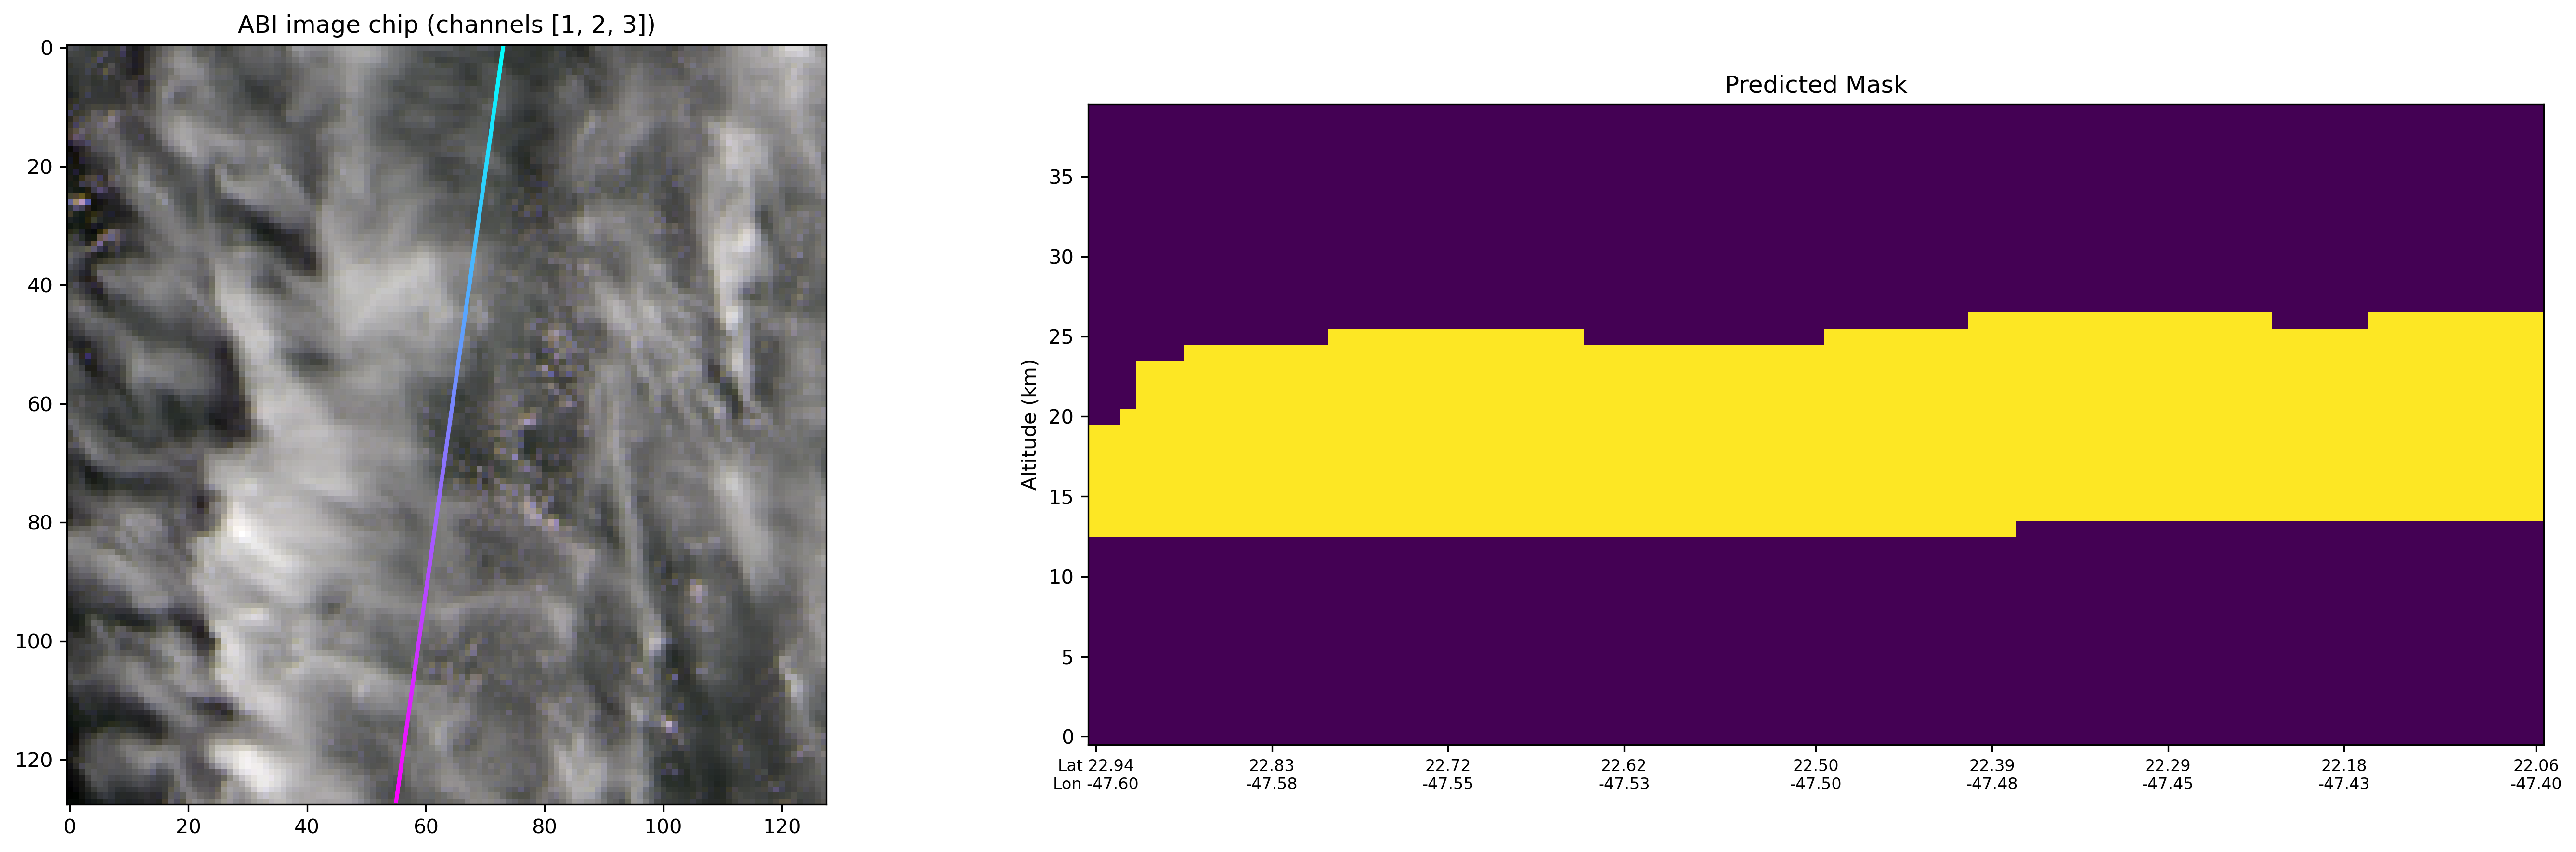

In [6]:
pred = torch.sigmoid(model(chip))
plot_rgb_chip_and_mask(chip, pred, lat, lon)